In [1]:
import datetime as dt
from tecton.dal.mantle import Mantle
from tecton.dal.instrument.futures.market import Markets
import tecton.calculator.signal.technical as tech

import numpy as np
import pandas as pd
idx = pd.IndexSlice

In [2]:
m = Mantle()
markets = Markets.from_config()

In [3]:
load_local = True
ix = ['asset', 'date']
if load_local:
    px = pd.read_parquet('fut.parquet')
    px = px.sort_values(ix).set_index(ix)
else:
    table = m.select('futures_cont', start_date=dt.date(2010, 1, 1), end_date=dt.date(2024, 12, 31))
    px = table.to_pandas()
    px = px.sort_values(ix).set_index(ix)
    px.to_parquet('fut.parquet')

In [4]:
top_liquid = px.index.get_level_values('asset').unique().tolist()
px = px.groupby('asset').ffill()

### Signals

In [5]:
mac_windows = [(5, 20), (10, 50), (20, 100), (50, 200)]
macd_windows = [(12, 26, 9), (21, 63, 15), (42, 126, 21), (63, 252, 42)]
dc_windows = [20, 50, 100, 200]
adx_windows = [63]
signals = px.copy(deep=True)
### Compute Signals Per Market
for root in top_liquid:
    ##### MAC #####
    mac = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for short_window, long_window in mac_windows:
        col = f'signal_{short_window}_{long_window}'
        mac.loc[:, col] = tech.ma_crossover(mac['price'].values, fast_period=short_window, slow_period=long_window,)
        signal_cols.append(col)
    mac.loc[:, 'signal'] = mac[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'mac'] = mac['signal']

    ##### MACD #####
    macd = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for short_window, long_window, signal_period in macd_windows:
        col = f'signal_{short_window}_{long_window}_{signal_period}'
        macd.loc[:, col] = tech.macd(macd['price'].values, fast_period=short_window, slow_period=long_window, signal_period=signal_period)
        signal_cols.append(col)
    macd.loc[:, 'signal'] = macd[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'macd'] = macd['signal']

    ##### DC #####
    dc = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for window in dc_windows:
        col = f'signal_{window}'
        dc.loc[:, col] = tech.donchian_channels(
            high=dc['trading_session_high_price'].values,
            low=dc['trading_session_low_price'].values,
            close=dc['price'].values,
            period=window)
        signal_cols.append(col)

    dc.loc[:, 'signal'] = dc[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'dc'] = dc['signal']

    ##### ADX #####
    adx = px.loc[idx[root, :], :].copy()
    signal_cols = []
    for window in adx_windows:
        col = f'signal_{window}'
        adx.loc[:, col] = tech.adx(
            high=adx['trading_session_high_price'].values,
            low=adx['trading_session_low_price'].values,
            close=adx['price'].values,
            period=window)
        signal_cols.append(col)

    adx.loc[:, 'signal'] = adx[signal_cols].sum(axis=1).div(len(signal_cols))
    # set in the main df
    signals.loc[idx[root, :], 'adx'] = adx['signal']

signals.loc[:, 'forecast'] = signals[['mac', 'macd', 'dc']].mean(axis=1) * signals['adx']

In [6]:
signals['return'] = signals.groupby('asset')['price'].pct_change()

In [7]:
signals['forecast_shifted'] = signals.groupby('asset')['forecast'].shift(2)

In [8]:
mask = signals['return'].abs() > 1
signals_clipped = signals.loc[~mask, :]

In [9]:
signals_clipped.loc[:, 'vol'] = signals_clipped.rolling(252, center=False)['return'].std().mul(252**0.5)

/tmp/ipykernel_15853/4068476058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_clipped.loc[:, 'vol'] = signals_clipped.rolling(252, center=False)['return'].std().mul(252**0.5)


In [17]:
signals_clipped.loc[:, 'weight'] = signals_clipped['forecast_shifted'] * (1/signals_clipped['vol']) / 30
rts = (signals_clipped.loc[:, 'weight'] * signals_clipped['return']).groupby('date').sum()

<Axes: xlabel='date'>

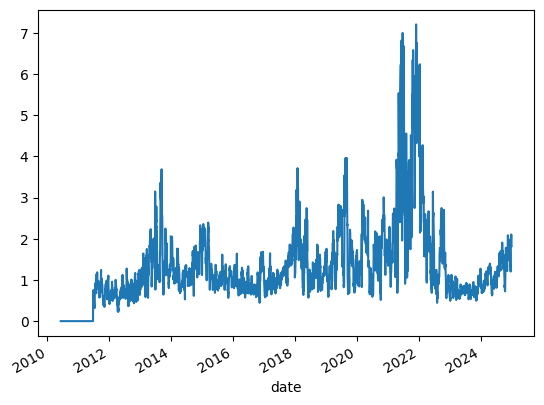

In [18]:
signals_clipped.assign(gross_wt=signals_clipped['weight'].abs()).groupby('date')['gross_wt'].sum().plot()

<Axes: xlabel='date'>

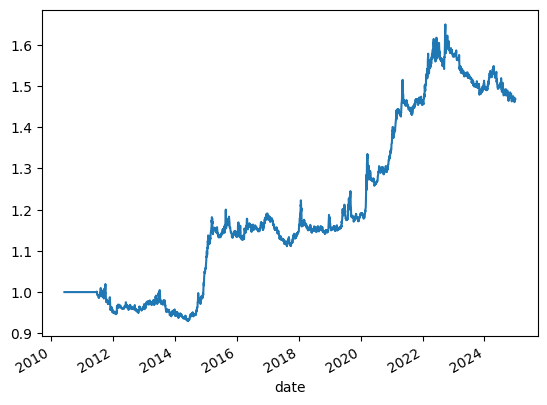

In [19]:
rts.add(1).cumprod().plot()

<Axes: xlabel='date'>

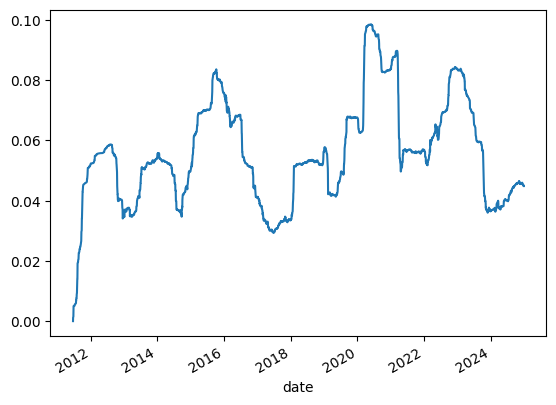

In [20]:
rts.rolling(252).std().mul(252**(1/2)).plot()

In [14]:
signals[mask]

symbol        price  open_interest  cleared_volume  \
asset date                                                            
GC    2012-02-06   GCJ2  17249.00000         238227          137271   
      2012-02-09   GCJ2  17412.00000         235628          163236   
MGC   2012-02-06  MGCJ2  17249.00000           1741            1133   
      2012-02-09  MGCJ2  17412.00000           2267            1594   
NG    2012-02-15   NGK2      2.73800         239154           64123   
      2012-03-01   NGK2      2.57900         249770           58682   
PL    2012-02-13   PLJ2   1649.70000          41147            7836   
      2012-03-01   PLJ2   1701.10000          38719            8181   
RP    2012-03-01   RPH2      0.83485          10752            1013   
SI    2012-02-08   SIH2    337.04000          40979           55084   
      2012-02-13   SIK2     33.75400          25859           10429   
ZM    2012-03-01   ZMK2    355.50000         101606           44187   
ZR    2012-03-01   ZRK2     14.24500          12027            1209   

                  opening_price  trading_session_low_price  \
asset date                                                   
GC    2012-02-06      17310.000                17140.00000   
      2012-02-09        173.440                  172.81000   
MGC   2012-02-06      17306.000                17143.00000   
      2012-02-09      17306.000                  172.80000   
NG    2012-02-15          2.630                    2.70600   
      2012-03-01          2.869                    2.56000   
PL    2012-02-13       1665.800                 1644.00000   
      2012-03-01       1717.200                 1694.90000   
RP    2012-03-01            NaN                    0.83385   
SI    2012-02-08          3.417                    3.36550   
      2012-02-13         33.660                   33.52500   
ZM    2012-03-01        352.200                  348.60000   
ZR    2012-03-01         14.440                   14.16000   

                  trading_session_high_price  lowest_offer  highest_bid   mac  \
asset date                                                                      
GC    2012-02-06                 17409.00000   17296.00000  17331.00000  1.00   
      2012-02-09                   175.54000   17296.00000  17347.00000  1.00   
MGC   2012-02-06                 17405.00000   17159.00000  17397.00000  1.00   
      2012-02-09                   175.52000     172.90000    175.48000  1.00   
NG    2012-02-15                     0.02838       0.02712      2.83500 -1.00   
      2012-03-01                     2.69100       2.64100      2.68800 -1.00   
PL    2012-02-13                    16.70700    1644.50000   1670.70000 -1.00   
      2012-03-01                  1706.80000    1695.90000   1704.30000 -1.00   
RP    2012-03-01                     0.83800       0.83375      0.83845 -0.75   
SI    2012-02-08                     3.45200       3.38850      3.42550  0.50   
      2012-02-13                    34.08000      33.53000     34.08500  0.50   
ZM    2012-03-01                   355.40000       3.32600      3.43700 -1.00   
ZR    2012-03-01                    14.62500      14.27000     14.49500 -1.00   

                  macd    dc       adx  forecast      return  forecast_shifted  
asset date                                                                      
GC    2012-02-06   1.0  1.00  0.199371  0.199371    8.911510          0.075450  
      2012-02-09   1.0  0.00  0.217283  0.144855   99.571825          0.073746  
MGC   2012-02-06   1.0  1.00  0.211762  0.211762    8.911510          0.080398  
      2012-02-09   1.0  0.00  0.229772  0.153182   99.571825          0.078095  
NG    2012-02-15  -1.0  0.00  0.251107 -0.167405   96.368421         -0.258196  
      2012-03-01  -0.5  0.00  0.277147 -0.138574   97.172821         -0.185379  
PL    2012-02-13  -1.0  0.50  0.440388 -0.220194    8.939149         -0.255921  
      2012-03-01  -0.5  0.75  0.600534 -0.150133   97.700319         -0.582

In [15]:
````

SyntaxError: invalid syntax (146514945.py, line 1)

In [ ]:
root = 'PA'
sd = dt.datetime(2020, 5, 10)
ed = dt.datetime(2020, 5, 16)

In [ ]:
signals.loc[idx[root, sd:ed], :]

symbol    price  open_interest  cleared_volume  \
asset date                                                        
PA    2020-05-11   PAM0  1828.10           4238            1431   
      2020-05-12   PAM0  1835.40           3848            1342   
      2020-05-13   PAU0  1790.55           3145             348   
      2020-05-14   PAU0  1796.65           3194             195   
      2020-05-15   PAU0  1856.40           3318             218   

                  opening_price  trading_session_low_price  \
asset date                                                   
PA    2020-05-11         1852.5                     1852.5   
      2020-05-12         1817.2                     1817.2   
      2020-05-13         1828.6                     1747.1   
      2020-05-14         1804.5                     1802.9   
      2020-05-15         1804.5                     1786.2   

                  trading_session_high_price  lowest_offer  highest_bid  mac  \
asset date                                                                     
PA    2020-05-11                      1887.4        1872.8       1879.2  NaN   
      2020-05-12                      1828.5        1828.5       1827.5  NaN   
      2020-05-13                      1831.7        1809.9       1740.0  NaN   
      2020-05-14                      1811.5        1807.0       1804.5  NaN   
      2020-05-15                      1871.8        1794.5       1867.0  NaN   

                  macd  dc  adx  forecast  forecast_shifted    return  
asset date                                                             
PA    2020-05-11   NaN NaN  NaN       NaN               NaN  0.003844  
      2020-05-12   NaN NaN  NaN       NaN               NaN  0.003993  
      2020-05-13   NaN NaN  NaN       NaN               NaN -0.024436  
      2020-05-14   NaN NaN  NaN       NaN               NaN  0.003407  
      2020-05-15   NaN NaN  NaN       NaN               NaN  0.033256

MA, MACD, BBANDS

multiplier: ADX

### MA Crossover

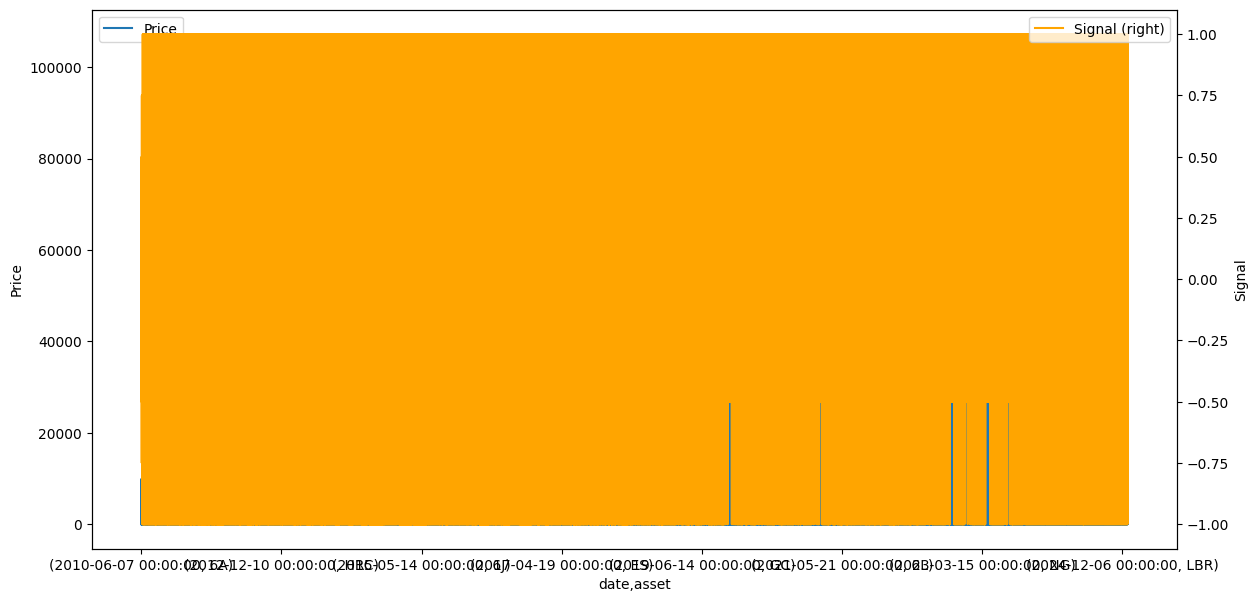

In [ ]:
mac = px[['price']].copy()

windows = [(5, 20), (10, 50), (20, 100), (50, 200)]
# windows = [(20, 100)]
signal_cols = []
for short_window, long_window in windows:
    col = f'signal_{short_window}_{long_window}'
    mac.loc[:, col] = tech.ma_crossover(px['price'].values, fast_period=short_window, slow_period=long_window,)
    signal_cols.append(col)

mac.loc[:, 'signal'] = mac[signal_cols].sum(axis=1).div(len(signal_cols))
#
ax = mac['price'].plot(label='Price', figsize=(14, 7))
mac['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

### MACD

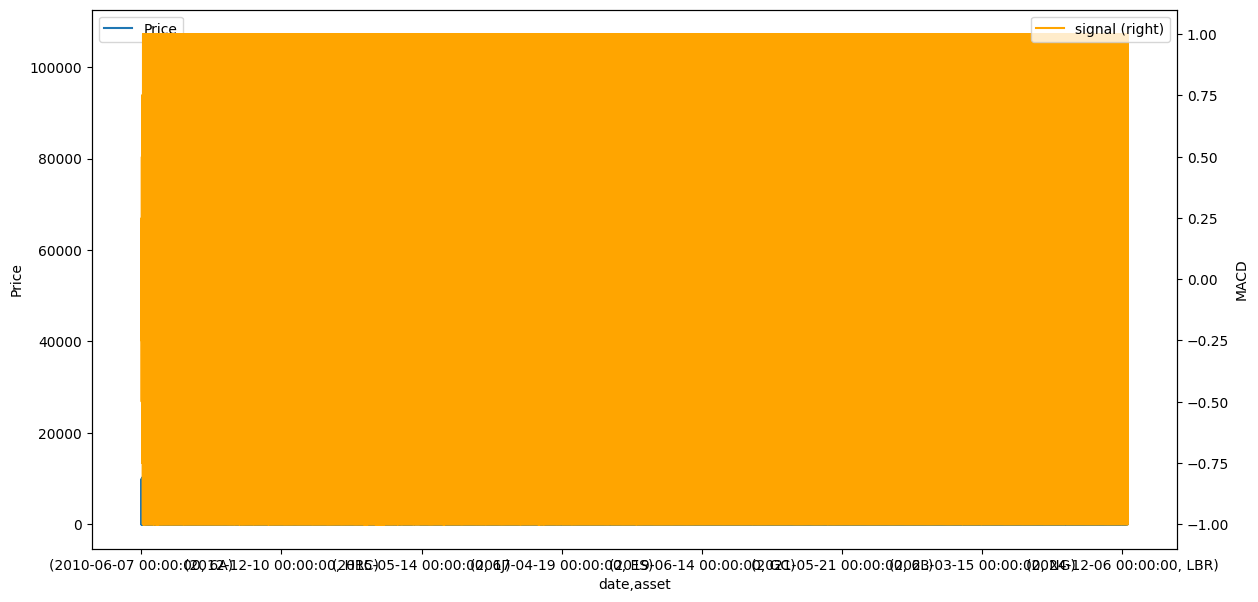

In [ ]:
macd = px[['price']].copy()

windows = [(12, 26, 9), (21, 63, 15), (42, 126, 21), (63, 252, 42)]
signal_cols = []
for short_window, long_window, signal_period in windows:
    col = f'signal_{short_window}_{long_window}_{signal_period}'
    macd.loc[:, col] = tech.macd(macd['price'].values, fast_period=short_window, slow_period=long_window, signal_period=signal_period)
    signal_cols.append(col)

macd.loc[:, 'signal'] = macd[signal_cols].sum(axis=1).div(len(signal_cols))

ax = macd['price'].plot(label='Price', figsize=(14, 7))
macd[['signal']].plot(ax=ax, secondary_y=True, label=['MACD', 'Signal'], color=['orange', 'purple'])
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('MACD')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

### Donchian Channels

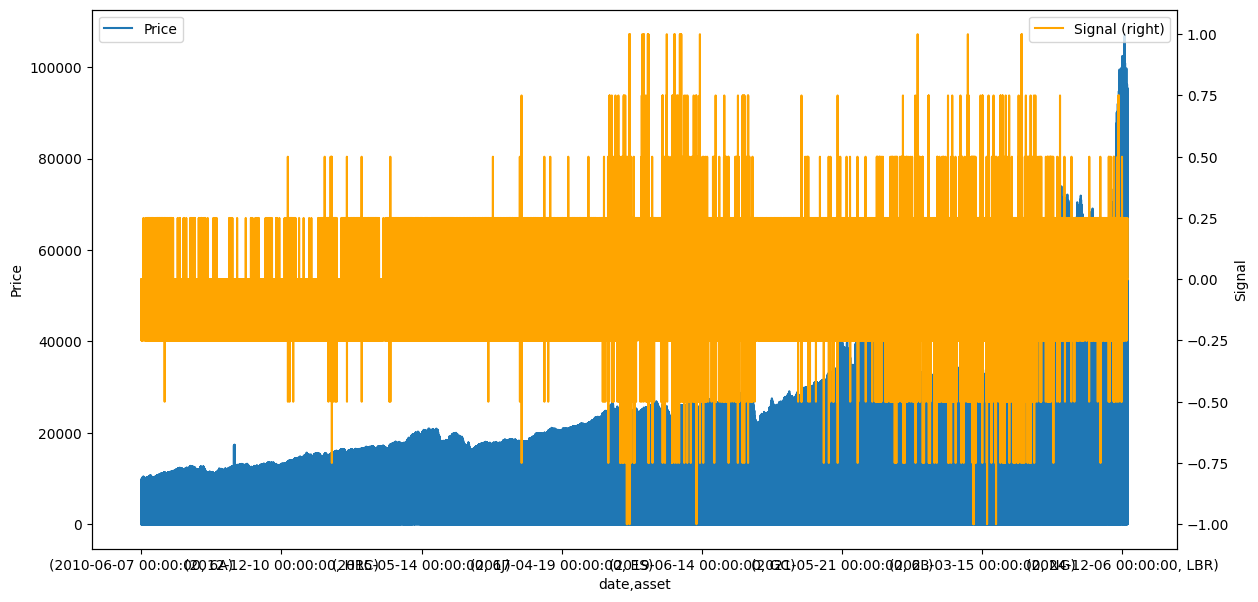

In [ ]:
dc = px[['price', 'trading_session_low_price', 'trading_session_high_price']].copy()

windows = [20, 50, 100, 200]
signal_cols = []
for window in windows:
    col = f'signal_{window}'
    dc.loc[:, col] = tech.donchian_channels(
        high=dc['trading_session_high_price'].values,
        low=dc['trading_session_low_price'].values,
        close=dc['price'].values,
        period=window)
    signal_cols.append(col)

dc.loc[:, 'signal'] = dc[signal_cols].sum(axis=1).div(len(signal_cols))
ax = dc['price'].plot(label='Price', figsize=(14, 7))
dc['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

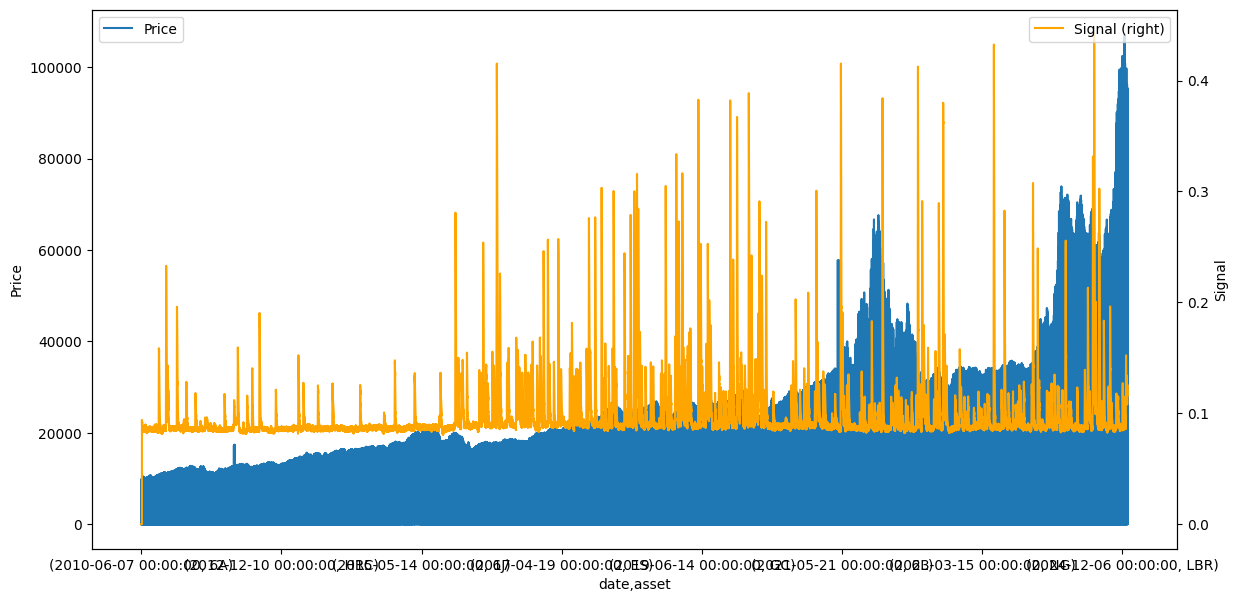

In [ ]:
adx = px[['price', 'trading_session_low_price', 'trading_session_high_price']].ffill().copy()

windows = [63]
signal_cols = []
for window in windows:
    col = f'signal_{window}'
    adx.loc[:, col] = tech.adx(
        high=adx['trading_session_high_price'].values,
        low=adx['trading_session_low_price'].values,
        close=adx['price'].values,
        period=window)
    signal_cols.append(col)

adx.loc[:, 'signal'] = adx[signal_cols].sum(axis=1).div(len(signal_cols))
ax = adx['price'].plot(label='Price', figsize=(14, 7))
adx['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

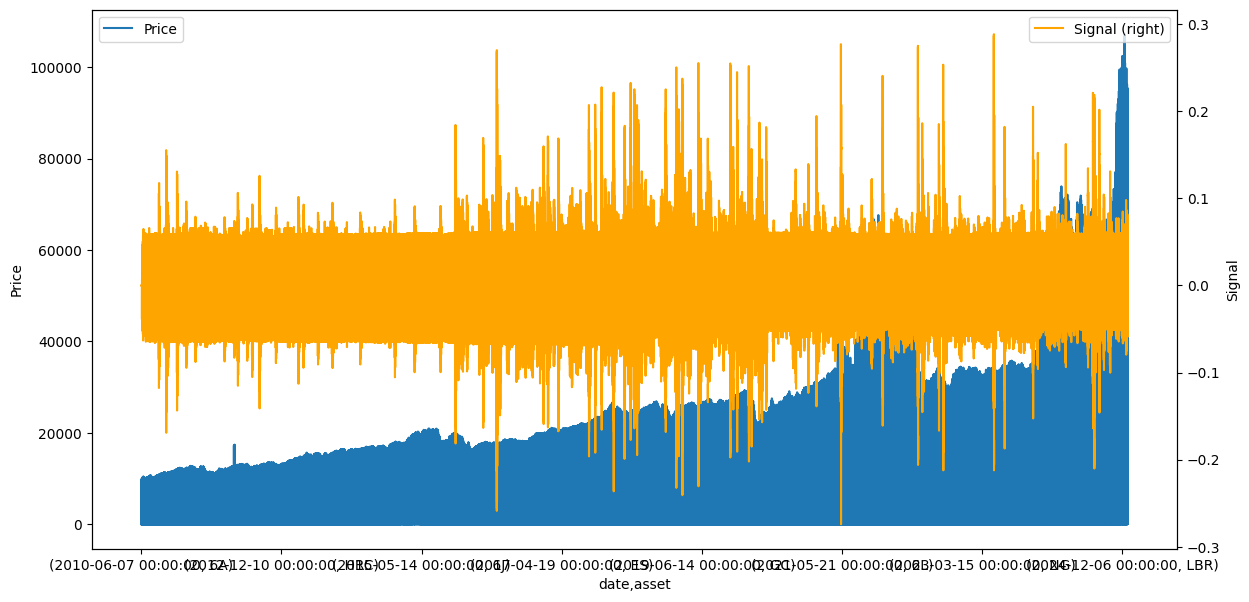

In [ ]:
signal = px[['price']].copy()
signal.loc[:, 'mac'] = mac['signal']
signal.loc[:, 'macd'] = macd['signal']
signal.loc[:, 'dc'] = dc['signal']
signal.loc[:, 'adx'] = adx['signal']
signal.loc[:, 'signal'] = signal[['mac', 'macd', 'dc']].mean(axis=1) * signal['adx']

ax = signal['price'].plot(label='Price', figsize=(14, 7))
signal['signal'].plot(ax=ax, secondary_y=True, label='Signal', color='orange')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel('Signal')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')